In [1]:
import os
import sys
from pathlib import Path

def find_project_root(marker=".git"):
    """Find the project root by looking for a marker file or directory."""
    current_path = Path.cwd()
    while current_path != current_path.parent:
        if (current_path / marker).exists():
            return current_path
        current_path = current_path.parent
    return None

project_root = find_project_root()
if project_root:
    src_path = project_root / "src"
    if str(src_path) not in sys.path:
        sys.path.insert(0, str(src_path))
else:
    print("Warning: Could not find project root. `gw2ml` may not be importable.", file=sys.stderr)

%load_ext dotenv
%reload_ext dotenv
%dotenv

In [2]:
from darts.models import ARIMA
import pandas as pd
import numpy as np
import matplotlib

In [ ]:
# Download source data from s3
from gw2ml.data.s3_sync import download_folder_from_s3

datapath = "data/train_arima/"


download_folder_from_s3(s3_folder_prefix='datasources/gw2/raw/1763399444', local_folder=datapath)
df = pd.read_csv(f'{datapath}Copper Ore.csv', delimiter=";")


ImportError: attempted relative import with no known parent package

<Axes: xlabel='fetched_at'>

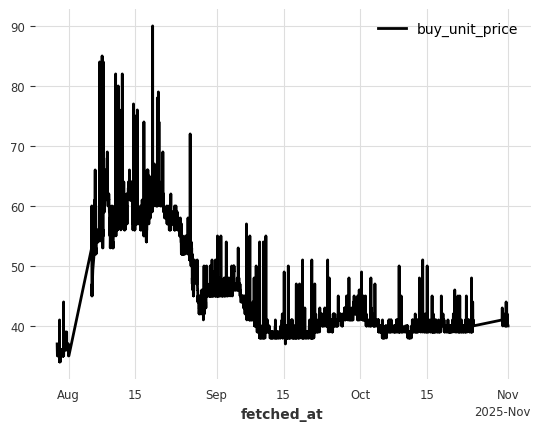

In [4]:
from darts import TimeSeries
value_cols = ["buy_unit_price"]  #ARIMA only univariate !

tsdf = df[value_cols + ['fetched_at']].copy()
# series = TimeSeries.from_dataframe(df, time_col="fetched_at")

# Convert to datetime and set as index
tsdf['fetched_at'] = pd.to_datetime(tsdf['fetched_at'])
# Localize timezone to UTC if it has timezone info, or remove it
if tsdf['fetched_at'].dt.tz is not None:
    tsdf['fetched_at'] = tsdf['fetched_at'].dt.tz_localize(None)
tsdf = tsdf.set_index('fetched_at')

# Resample to exact 5-minute intervals, forward-filling missing values
tsdf_resampled = tsdf[value_cols].resample('5min').mean().interpolate(method='linear')

# Create TimeSeries (no need for fill_missing_dates now)
series = TimeSeries.from_dataframe(tsdf_resampled, value_cols=value_cols)
series.plot()


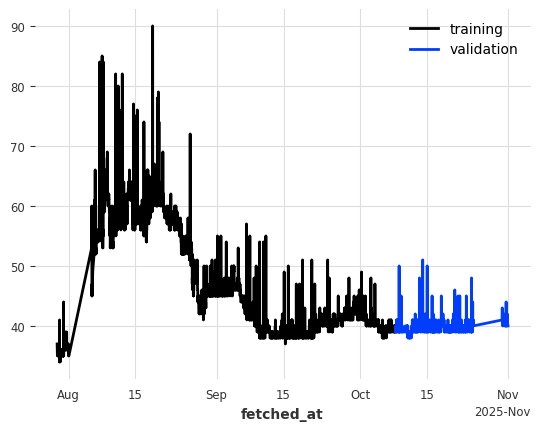

In [5]:
train, val = series.split_after(0.75)
train.plot(label="training")
val.plot(label="validation");


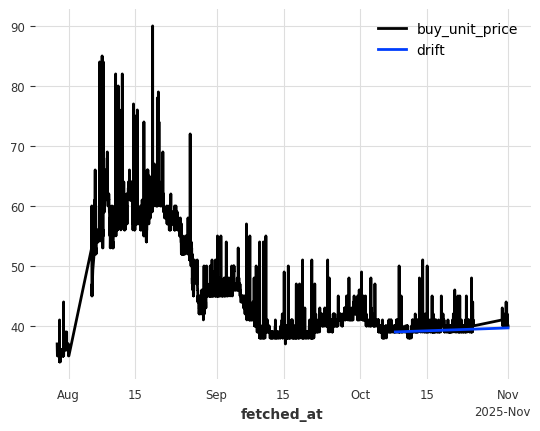

In [6]:
from darts.models import NaiveDrift

drift_model = NaiveDrift()
drift_model.fit(train)
# Predict only the length of the validation set
drift_forecast = drift_model.predict(len(val))

series.plot()
drift_forecast.plot(label="drift");

In [7]:
import mlflow

mlflow.set_experiment("Arima")

2025/11/18 15:34:46 INFO mlflow.tracking.fluent: Experiment with name 'Arima' does not exist. Creating a new experiment.


<Experiment: artifact_location='s3://mlflow/3', creation_time=1763476486326, experiment_id='3', last_update_time=1763476486326, lifecycle_stage='active', name='Arima', tags={}>

In [8]:
# ... existing code ...
from darts.metrics import mape
from darts.models import ARIMA

best_mape = float('inf')
best_params = None

# Start MLflow run for hyperparameter tuning
with mlflow.start_run(run_name="ARIMA_Grid_Search"):
    mlflow.log_param("search_p_range", "0-3")
    mlflow.log_param("search_d_range", "0-1")
    mlflow.log_param("search_q_range", "0-3")
    mlflow.log_param("train_size", len(train))
    mlflow.log_param("val_size", len(val))

    for p in range(0, 4):
        for d in range(0, 2):
            for q in range(0, 4):
                # Start nested run for each parameter combination
                with mlflow.start_run(run_name=f"ARIMA_{p}_{d}_{q}", nested=True):
                    try:
                        model = ARIMA(p=p, d=d, q=q)
                        model.fit(train)
                        forecast = model.predict(len(val))
                        error = mape(val, forecast)

                        # Log parameters and metrics
                        mlflow.log_param("p", p)
                        mlflow.log_param("d", d)
                        mlflow.log_param("q", q)
                        mlflow.log_metric("mape", error)

                        if error < best_mape:
                            best_mape = error
                            best_params = (p, d, q)
                            print(f"New best: ARIMA{best_params} with MAPE: {error:.2f}%")

                            # Log the best model so far
                            mlflow.log_param("is_best", True)
                        else:
                            mlflow.log_param("is_best", False)

                    except Exception as e:
                        mlflow.log_param("error", str(e))
                        print(f"ARIMA({p},{d},{q}) failed: {e}")

    # Log best results in parent run
    mlflow.log_param("best_p", best_params[0])
    mlflow.log_param("best_d", best_params[1])
    mlflow.log_param("best_q", best_params[2])
    mlflow.log_metric("best_mape", best_mape)

print(f"Best model: ARIMA{best_params} with MAPE: {best_mape:.2f}%")

New best: ARIMA(0, 0, 0) with MAPE: 16.10%
🏃 View run ARIMA_0_0_0 at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/3/runs/cbf68d753734412f8834c600f5c1a44c
🧪 View experiment at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/3
New best: ARIMA(0, 0, 1) with MAPE: 16.10%
🏃 View run ARIMA_0_0_1 at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/3/runs/6fcecb914c7541a1b659248342da50cf
🧪 View experiment at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/3
New best: ARIMA(0, 0, 2) with MAPE: 16.10%
🏃 View run ARIMA_0_0_2 at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/3/runs/68c846737d4048d792443e259da75d9b
🧪 View experiment at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/3
New best: ARIMA(0, 0, 3) with MAPE: 16.10%
🏃 View run ARIMA_0_0_3 at: 

/home/lukas/Documents/Github/casml4se-stonkswagen/notebooks/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/lukas/Documents/Github/casml4se-stonkswagen/notebooks/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


🏃 View run ARIMA_3_0_2 at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/3/runs/370516d96fb84f39aa3a258c8085a226
🧪 View experiment at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/3


/home/lukas/Documents/Github/casml4se-stonkswagen/notebooks/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


🏃 View run ARIMA_3_0_3 at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/3/runs/af7a8b09d6a941e0ae4a08321130e661
🧪 View experiment at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/3
🏃 View run ARIMA_3_1_0 at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/3/runs/f7226454290943169ed7aa7a898bc4c7
🧪 View experiment at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/3
🏃 View run ARIMA_3_1_1 at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/3/runs/df294498d0814b089747184bec64195c
🧪 View experiment at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/3
🏃 View run ARIMA_3_1_2 at: http://lukas-hp-z2-mini-g1a-workstation-desktop-pc.tail7adb49.ts.net:5000/#/experiments/3/runs/06c55007300e4fc784405f70e052e868
🧪 View experiment at: http://lukas-hp-z2-min

In [10]:
from darts.models import Theta, NaiveDrift
from darts.metrics import mape


def eval_model(model):
    model.fit(train)
    forecast = model.predict(len(val))
    print(f"model {model} obtains MAPE: {mape(val, forecast):.2f}%")


eval_model(NaiveDrift())
eval_model(ARIMA())
eval_model(Theta())
eval_model(ARIMA(p=2, d=0, q=2))

model NaiveDrift() obtains MAPE: 1.78%
model ARIMA() obtains MAPE: 2.13%
model Theta() obtains MAPE: 5.47%
model ARIMA(p=2, d=0, q=2) obtains MAPE: 1.51%
